# Clustering And Outlier Analysis

Clustering is the task of finding clusters of 'similar' points in a datasset

This might be useful for gaining insights into the data, finding outliers etc.

In [1]:
import numpy as np
N_CLUSTERS = 4
N_SAMPLES = 1500
RANDOM_STATE = 42
COLORS = ['#7ebdb4', '#f6d198', '#f4a548', '#862a5c']
LABEL_FONTSIZE = 20
OUTLIERS = np.array([[100, 200], [150, -100], [300, 64], [-40, 10], [130, 50]])

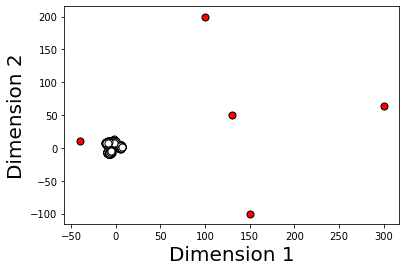

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# create dataset
X, _ = make_blobs(
   n_samples=N_SAMPLES, n_features=2,
   centers=N_CLUSTERS, cluster_std=1,
   shuffle=True, random_state=RANDOM_STATE)


# plot
plt.scatter(
   X[:, 0], X[:, 1],
   c='white', marker='o',
   edgecolor='black', s=50)
plt.scatter(
    OUTLIERS[:, 0], OUTLIERS[:, 1],
    c='red', marker='o',
    edgecolor='black', s=50)
plt.xlabel('Dimension 1', fontsize=LABEL_FONTSIZE)
plt.ylabel('Dimension 2', fontsize=LABEL_FONTSIZE)

plt.show()

The uncolored blobs (99.7% of the data) represent raw data which has not been clustered. The red points are the outliers. Note that the outliers make it difficult to see any structure in the real data. This is a common problem for machine learning algorithms: outliers make it hard for the algorithms to discern useful correlations in the data. Outliers thus, need to be cleaned up before proceeding further.


<b> Data Cleaning - Outlier Removal </b>

In [3]:
X_outliers = np.concatenate((X, OUTLIERS))
from sklearn.ensemble import IsolationForest
iforest = IsolationForest(contamination=0.003,
                         random_state=RANDOM_STATE)
iforest.fit(X_outliers)
outlier_preds = iforest.predict(X_outliers)  # outputs -1 for points it believes to be outliers
# find the outliers identified by the model
print(X_outliers[outlier_preds == -1 , :]) # printd the points which have been labelled as -1 (outlier)

[[ 100.  200.]
 [ 150. -100.]
 [ 300.   64.]
 [ -40.   10.]
 [ 130.   50.]]


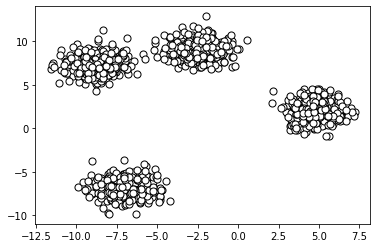

In [4]:
# lets remove these points from the dataset, retaining only inliers
X = X_outliers[outlier_preds != -1 , :]
# plot
plt.scatter(
   X[:, 0], X[:, 1],
   c='white', marker='o',
   edgecolor='black', s=50)
plt.show()

Now, with the outliers removed, we begin to see structure in the data!
We are ready to cluster it using sklearn's K-Means functionality.

<b> Clustering using K-means </b>

K-means is the simplest clustering algorithm which identifies a specified number of clusters in the data. Let's try it out!

Recall that K-means needs to be given number of clusters to find. However, we normally don't know this a-priori. To find the optimum number of clusters, we use the silhouette scores that different choices of cluster numbers give.

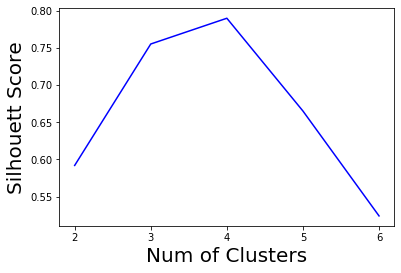

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

clusters_to_find = [2, 3, 4, 5, 6]
silhouette_scores = []
for num_clusters in clusters_to_find:
    k_means = KMeans(
        n_clusters=num_clusters, init='random',   # note that we know a-priori how many clusters there are
        random_state=RANDOM_STATE)
    clusters = k_means.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, clusters))
plt.plot(clusters_to_find, silhouette_scores, 'b-')
plt.xlabel('Num of Clusters', fontsize=LABEL_FONTSIZE)
plt.xticks(clusters_to_find)
plt.ylabel('Silhouett Score', fontsize=LABEL_FONTSIZE)
plt.show()

We see that the silhoutte size is maximized for 4 clusters. So we choose that and re-fit the algorithm and plot its performance.

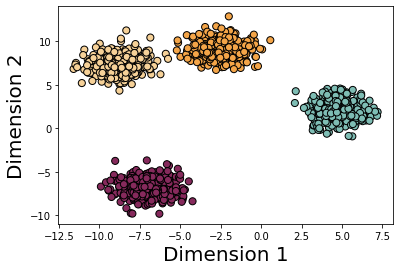

In [6]:
k_means = KMeans(
        n_clusters=4, init='random',
        random_state=RANDOM_STATE)
clusters = k_means.fit_predict(X)
plt.scatter(
   X[:, 0], X[:, 1],
   c=[COLORS[cluster] for cluster in clusters], 
    marker='o',
   edgecolor='black', s=50)
plt.xlabel('Dimension 1', fontsize=LABEL_FONTSIZE)
plt.ylabel('Dimension 2', fontsize=LABEL_FONTSIZE)
plt.show()

K-Means seems to have done a good job! 

Note however, that this dataset was artificially generated and thus clean. In real scenarios, it is difficult to know a-priori how many clusters are there in the data, limiting the use of k-means.

<b> Gaussian Mixture Models </b>

Gaussian Mixture Modelss (GMM) provide a probabilistic basis for clustering. It assumes that the data is generated from an underlying distribution of k normal distribtuions chosen at random. It then tries to find these normal distributions. Let's see it action using the same dataset.

<b> Data Cleaning - Outlier Removal</b>

Data cleaning can be achieved by GMM by eliminatingg points which lie in low probability densities

[ -3.48451793  -4.70043439  -5.29327993 ... -18.06696569 -18.03977493
 -16.80324285]


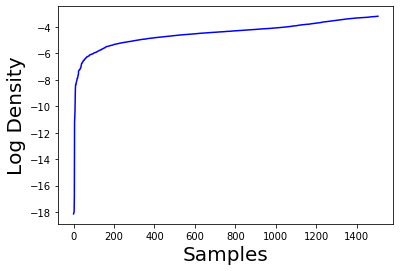

In [15]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=4, n_init=10)
gm.fit(X_outliers)
assert gm.converged_  # check convergence
densities = gm.score_samples(X_outliers)  # gives log likelihoods
print(densities)
plt.plot([_ for _ in range(len(densities))], np.sort(densities), 'b-')
plt.xlabel('Samples', fontsize=LABEL_FONTSIZE)
plt.ylabel('Log Density', fontsize=LABEL_FONTSIZE)
plt.show()

In [16]:
density_threshold = np.percentile(densities, 0.3)  # 0.3% of the data are outliers
anomalies = X_outliers[densities < density_threshold]
print(anomalies)

[[ 100.  200.]
 [ 150. -100.]
 [ 300.   64.]
 [ -40.   10.]
 [ 130.   50.]]


It identifies the outliers! Now that we have identified the outliers, we can remove them as before. In the following, we directly use the clean dataset we made in the previous section. Let's find clusters using GMM!

As before, we need to identify the number of clusters a-priori. Like before, we need a criterion for the selection of this hyperperamater. We cannot use the silhouette score since it is exclusively applicable to spherical clusters. Here, we use the Bayesian Information Criterion (BIC) which rewards a simple model which fits the data well

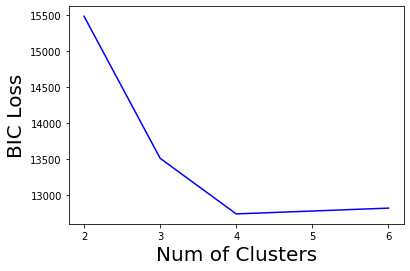

In [17]:
bic_losses = []   # this is called a loss not a score because we minimize it
for num_clusters in clusters_to_find:
    gm = GaussianMixture(n_components=num_clusters, 
                         n_init=10, 
                         random_state=RANDOM_STATE)
    gm.fit(X)  # we use the clean dataset
    bic_losses.append(gm.bic(X))
plt.plot(clusters_to_find, bic_losses, 'b-')
plt.xlabel('Num of Clusters', fontsize=LABEL_FONTSIZE)
plt.xticks(clusters_to_find)
plt.ylabel('BIC Loss', fontsize=LABEL_FONTSIZE)
plt.show()

Note the shoulder at 4. This is chosen as the optimal number of clusters. Let's re-fit the model using this hyuperparameter value!

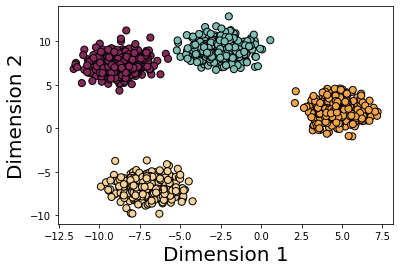

In [18]:
gm = GaussianMixture(n_components=4, 
                         n_init=10, 
                         random_state=RANDOM_STATE)

clusters = gm.fit_predict(X)
plt.scatter(
   X[:, 0], X[:, 1],
   c=[COLORS[cluster] for cluster in clusters], 
    marker='o',
   edgecolor='black', s=50)
plt.xlabel('Dimension 1', fontsize=LABEL_FONTSIZE)
plt.ylabel('Dimension 2', fontsize=LABEL_FONTSIZE)
plt.show()

As before, we have identified the clusters pretty well!

<b>Conclusion</b>
Clustering is often a science/ art combination on real, noisy data. You might have to iterate between data cleaning and clustering to get incremental insights into the data. However, once we do find the clusters, we can make simpler and more expressive models!